In [36]:
# Imports and Dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import gspread
from datetime import date
import matplotlib.pyplot as plt

## Grab stock data from Google Sheets

### I choose:

    * CLOV
    * SNDL
    * MARA
    * GME

In [3]:
# Get credentials for Google Sheets Stock Data
gc = gspread.service_account(Path("/home/commander/Programs/SchoolWork/upenn-python-homework/WhaleAnalysis/Credentials/schoolstockdata-c423c875dcfe.json"))
# Grab Stock Data's first sheet
sh = gc.open("Stock Data").get_worksheet(0)
# List of selected tickers
tickers = ['CLOV', 'SNDL', 'MARA', 'GME', '.IXIC']
# Empty DataFrame for historical price data
all_prices = pd.DataFrame()

## Iterate through list of tickers

    * Put ticker in Google Finance function string
    * Send string to Google Sheets cell A1
    * Grab historical price data and store in a Pandas DataFrame

In [4]:
# Loop through tickers
for ticker in tickers:
    # Function in Google Sheets
    google_finance_function = f'=GOOGLEFINANCE("{ticker}", "price", "1/1/2020", "6/1/2021")'
    sh.update('A1', google_finance_function, value_input_option="USER_ENTERED")
    # List of Lists used to create DataFrame
    price_data = sh.get_all_values()
    stock_df = pd.DataFrame(price_data[1:], columns=price_data[0])
    # Set index as a datetime object
    stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
    stock_df = stock_df.set_index('Date')
    stock_df = stock_df.rename(columns={"Close": ticker})
    # Concat DataFrames together
    all_prices = all_prices.join(stock_df, how='right')

In [5]:
# Set NASDAQ name for column
all_prices = all_prices.rename(columns={'.IXIC': 'NASDAQ'})
# Drop null values
all_prices = all_prices.dropna()
# Change data types
all_prices = all_prices.astype('float')
# Calculate daily returns
daily_returns = all_prices.pct_change()
daily_returns = daily_returns.dropna()

## Calculate the following for Portfolio Optimization

### Weighted Returns
    * Determines the overall balance of the quantity of assets
    * Can be used to redistribute assets for better risk-return ratio

### Annualized Standard Deviation
    * Used in calculating risk
    * Can help determine which asset has more volatility and/or risk involved

### Correlation
    * Measure of one assets frequency to another
    * Can help deciding how weighted an asset should be by the factor of correlation to one another

### Beta (NASDAQ)
    * Calculates corresponding assets price movement based on a standard index
    * I chose the NASDAQ as i felt it better related to the chosen list of stocks
    * Can be used to understand volatility and price action in relation to a more stable asset

### Sharpe ratio
    * Ratio that measures an assets returns in relation to its volatility/risk
    * A great tool for deciding if certain assets were worth the risk compared to their gains of assets with similar gains

In [6]:
# Initialize weights
weights = [.25, .25, .25, .25, 0]
# Weighted Returns
weighted_returns = daily_returns.dot(weights).dropna()
daily_returns['MyReturns'] = weighted_returns
weighted_returns.head(5)

Date
2020-06-15    0.014706
2020-06-16   -0.001103
2020-06-17   -0.029365
2020-06-18    0.003961
2020-06-19   -0.020338
dtype: float64

<AxesSubplot:title={'center':'Annual Standard Deviation'}, xlabel='Entity'>

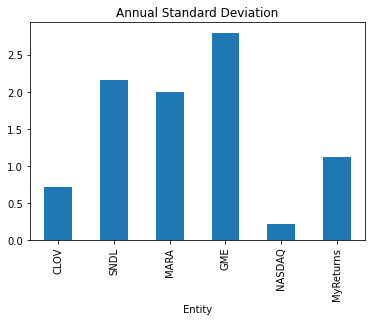

In [31]:
# Annual Standard Deviation
annual_standard_deviation = daily_returns.std() * np.sqrt(252)
annual_standard_deviation.plot(kind='bar', title="Annual Standard Deviation", xlabel="Entity")

Text(0.5, 0, 'Date')

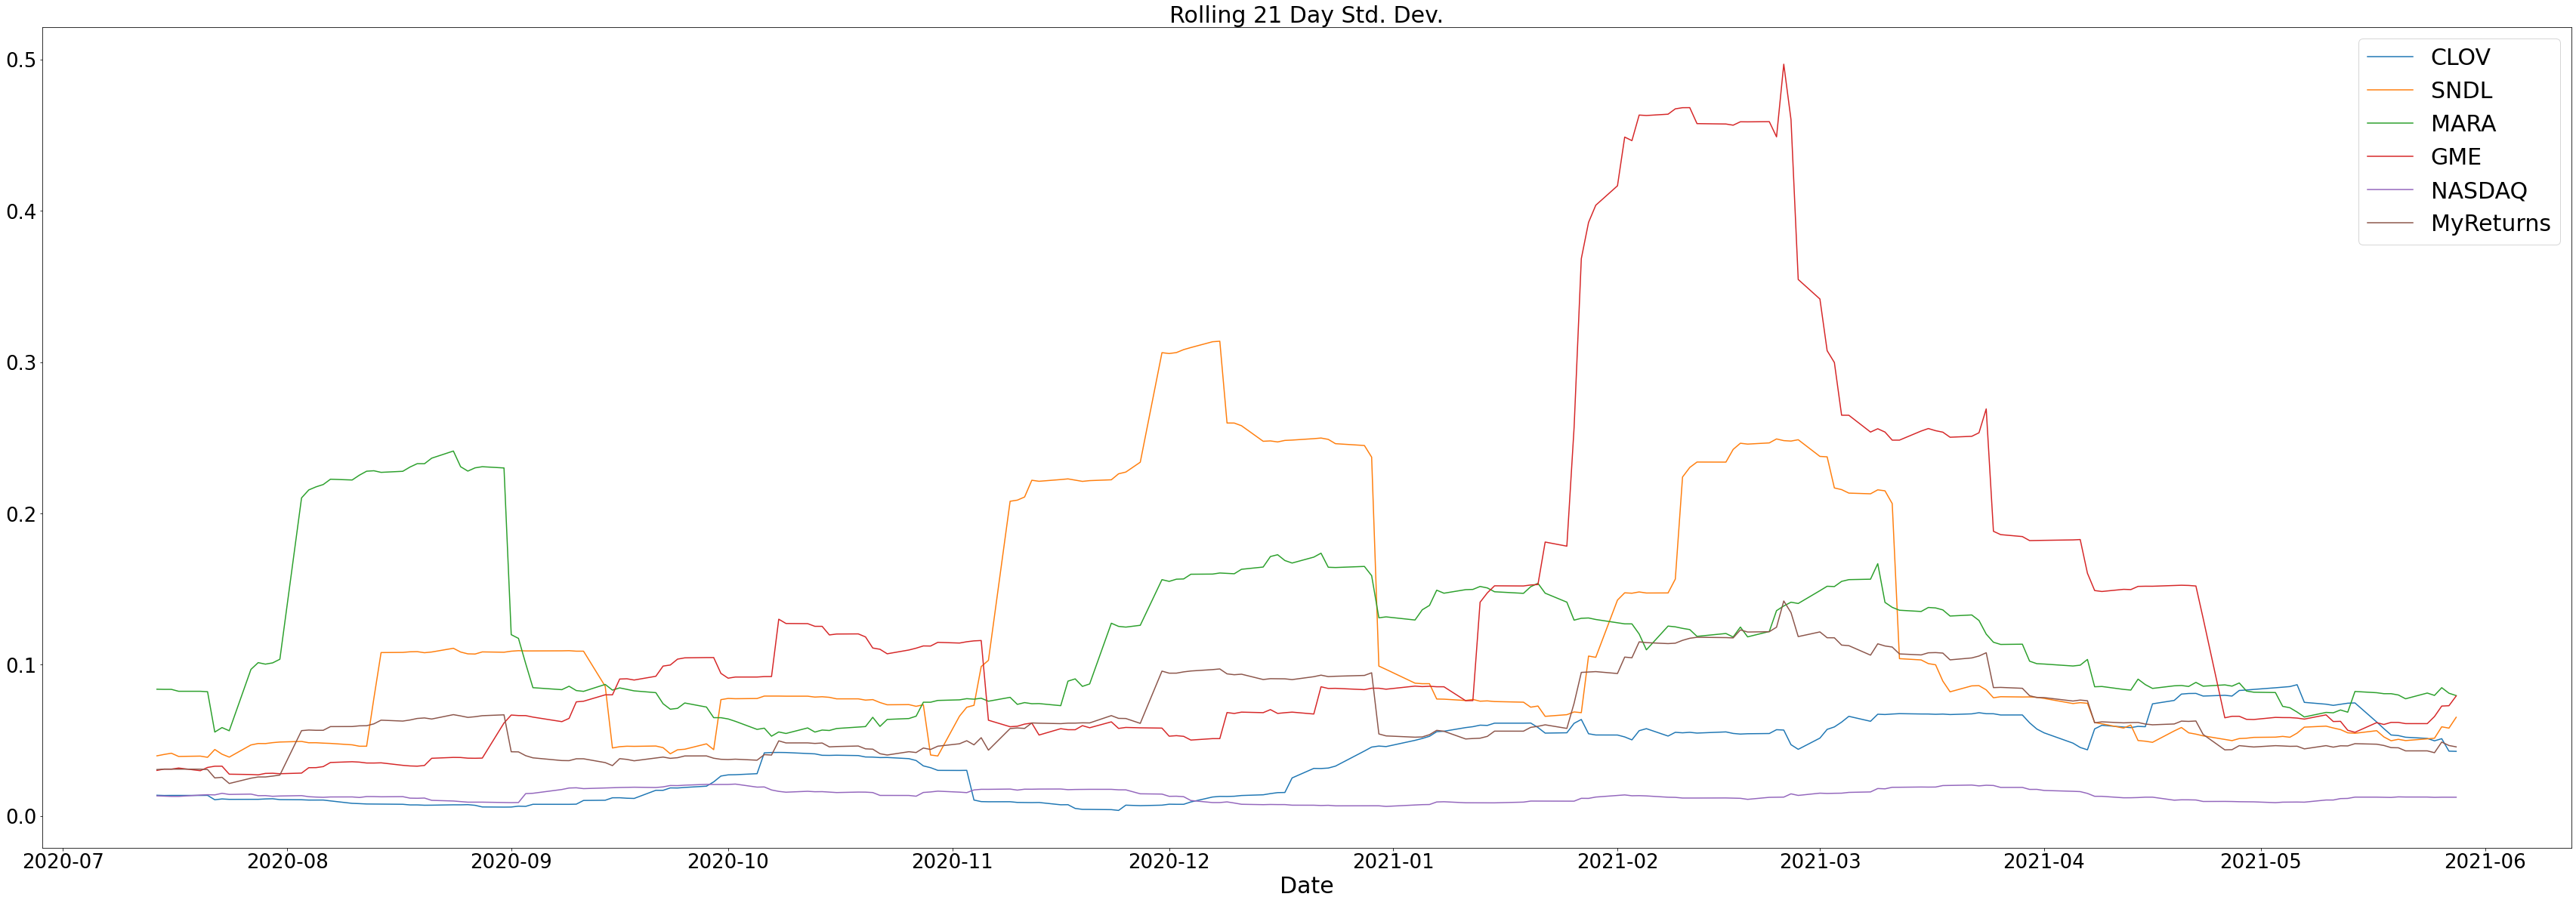

In [42]:
# Rolling Standard Deviation
rolling_21_standard_deviation = daily_returns.rolling(window=21).std()
fig, ax = plt.subplots()
rolling_21_standard_deviation.plot(figsize=(60,20), fontsize=26, ax=ax)
ax.legend(fontsize=30)
ax.set_title("Rolling 21 Day Std. Dev.", fontsize=30)
ax.set_xlabel('Date', fontsize=30)

Text(0.5, 0, 'Entity')

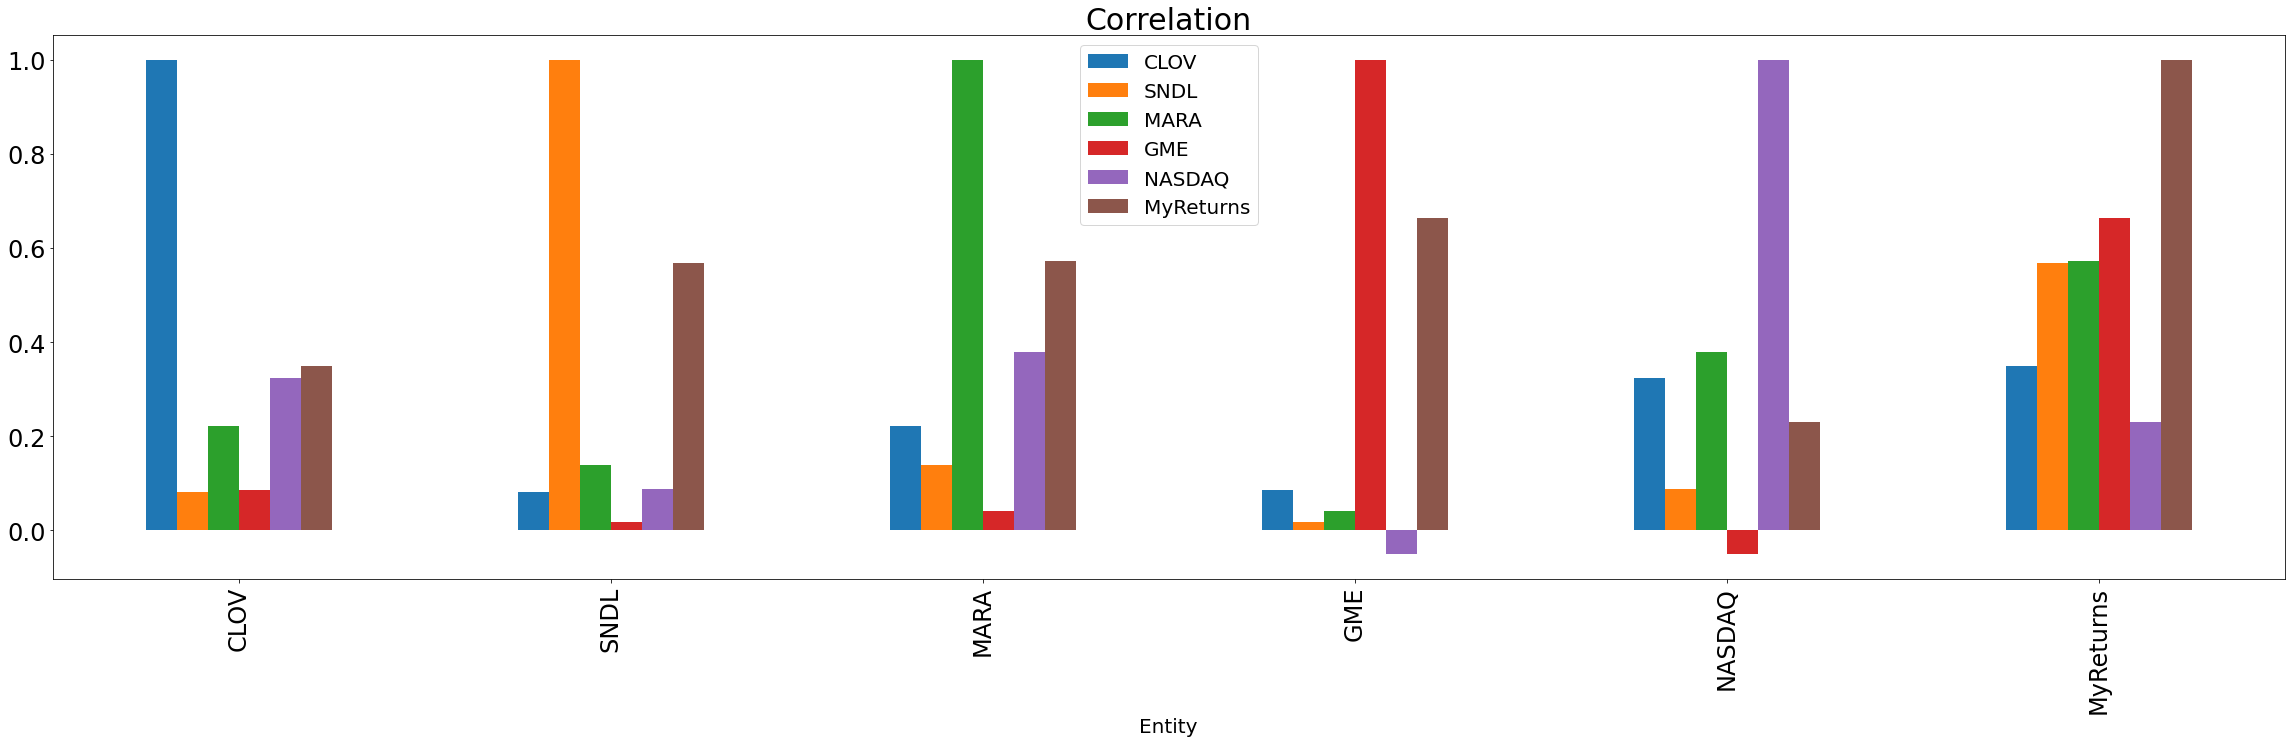

In [53]:
# Correlation
correlation = daily_returns.corr()
fig, ax = plt.subplots()
correlation.plot(kind="bar", figsize=(40, 10), ax=ax, fontsize=24)
ax.set_title("Correlation", fontsize=30)
ax.legend(fontsize=20, loc='upper center')
ax.set_xlabel("Entity", fontsize=20)

Text(0.5, 1.0, 'Beta (My Portfolio / NASDAQ)')

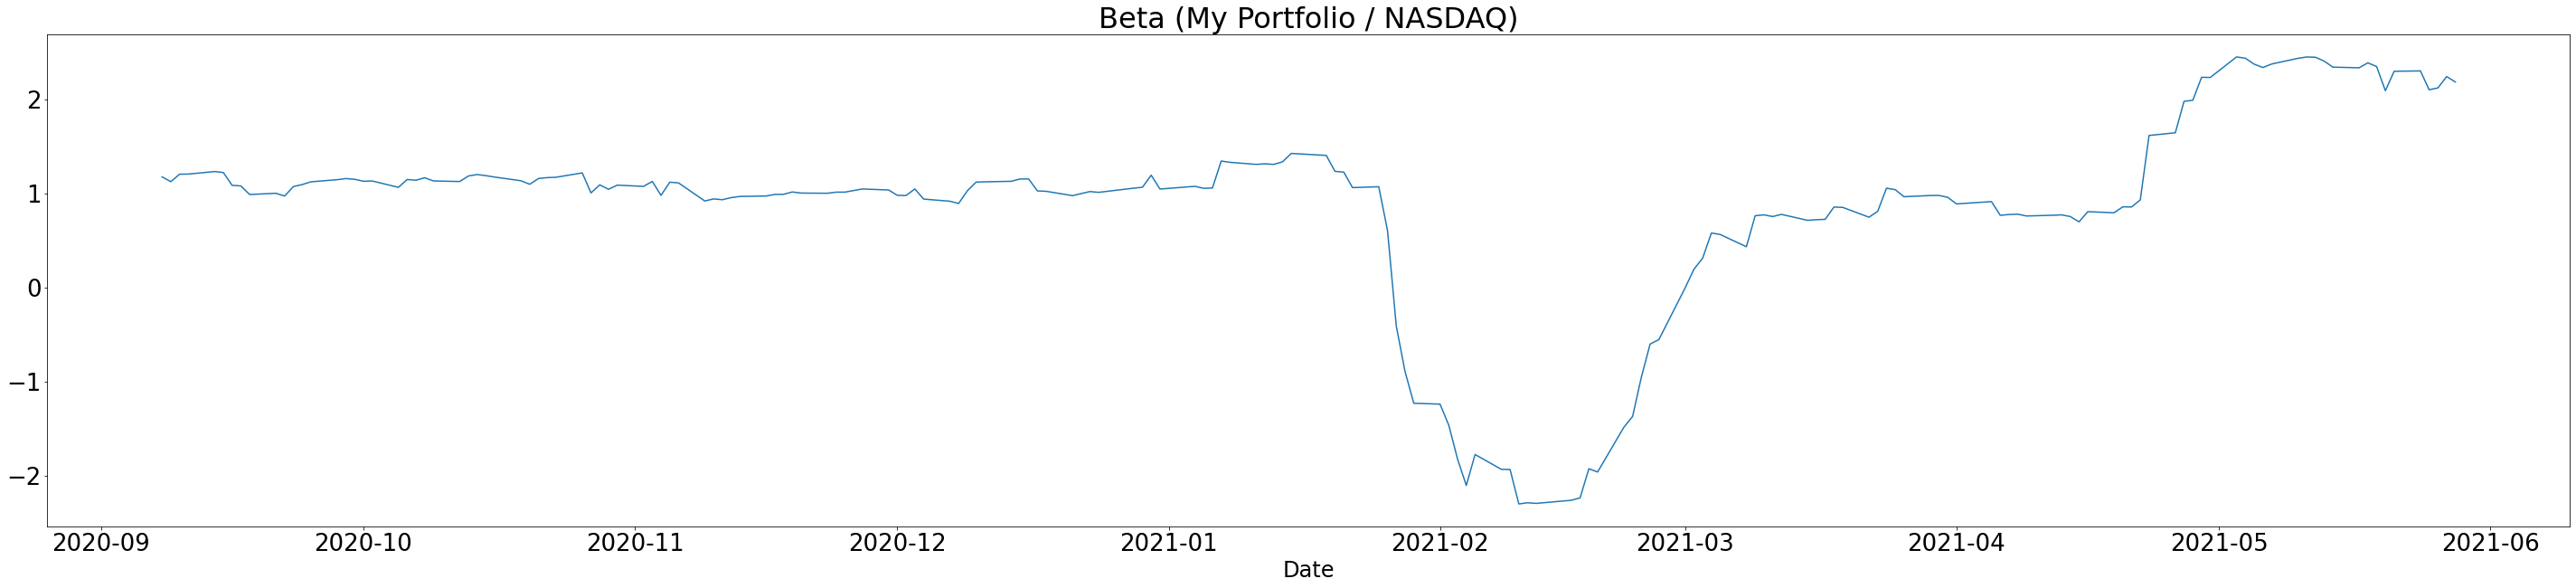

In [56]:
# Beta (60 day compared to NASDAQ)
nasdaq_variance = daily_returns['NASDAQ'].rolling(window=60).var()
my_covariance = daily_returns['MyReturns'].rolling(window=60).cov(daily_returns['NASDAQ'])
my_beta = my_covariance / nasdaq_variance
fig, ax = plt.subplots()
my_beta.plot(figsize=(50,10), fontsize=26, ax=ax)
ax.set_xlabel('Date', fontsize=24)
ax.set_title("Beta 60 Day(My Portfolio / NASDAQ)", fontsize=32)

<AxesSubplot:title={'center':'Sharpe Ratio'}, xlabel='Entity'>

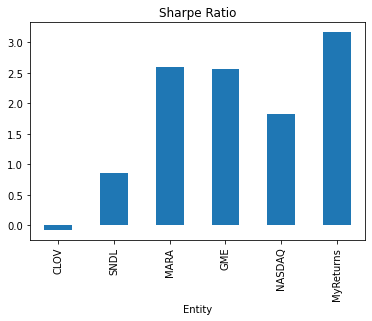

In [58]:
# Sharpe Ratio
my_sharpe_ratio = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
my_sharpe_ratio.plot(kind="bar", title="Sharpe Ratio", xlabel="Entity")

# Conclusion

### Rebalancing
    * The portfolio in general needs a weight adjustment to mitigate the volatility of certain assets
    * Some correlation between MARA and CLOV is noticed yet them being in different sectors

### Volatility
    * Need to have more stable assets to average out risk-return ratio
    * Feels more like a gamble than an investment with this portfolio

### Longer Holds
    * I think these assets are meant for day trading and scalping mainly
    * Personally would advise to enter/exit these assets quickly
    * Build the portfolio base with a stronger more stable foundation of assets

# Negative Beta

    * The daily returns over 1 might explain the negative Beta yet I am unsure how to fully interpret it 
    * I just know the correlation was negative between GME and the NASDAQ as well

In [27]:
daily_returns[daily_returns.values > 1]

,CLOV,SNDL,MARA,GME,NASDAQ,MyReturns
Date,,,,,,
2021-01-27,-0.095812,0.071429,-0.051075,1.348358,-0.026087,0.318225
2021-02-24,0.020731,0.150794,0.169818,1.039360,0.009860,0.345175


In [59]:
correlation[correlation.values < 0]

,CLOV,SNDL,MARA,GME,NASDAQ,MyReturns
GME,0.084476,0.017217,0.039776,1.000000,-0.051104,0.664630
NASDAQ,0.323641,0.086504,0.377914,-0.051104,1.000000,0.229426


## [This morningstar article](https://www.morningstar.in/posts/36419/can-beta-be-negative.aspx) and [DFV's reddit post](https://www.reddit.com/r/DeepFuckingValue/comments/m6k7hm/abnormal_negative_beta_gme/) helped but I still don't feel confident enough to make an assessment